In [8]:
import cv2 as cv
#import common
import numpy as np
import time

#the following are to do with this interactive notebook code
%matplotlib inline 
from matplotlib import pyplot as plt

# Reading Image

(548, 821, 3)


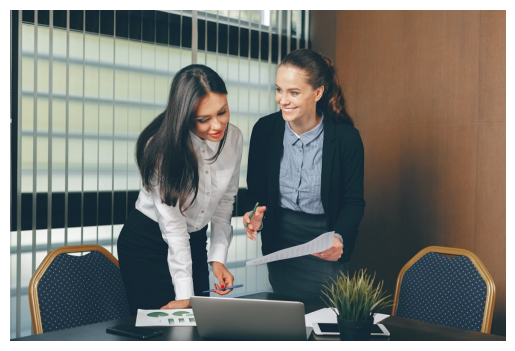

In [117]:
#Reading Image
path = r"C:\Users\Fernanda Januar\women-looking-financial-documents.jpg"
image = cv.imread(path)

print(image.shape)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Getting Blob

### Example Blob

(1280, 3)
(1280, 3)


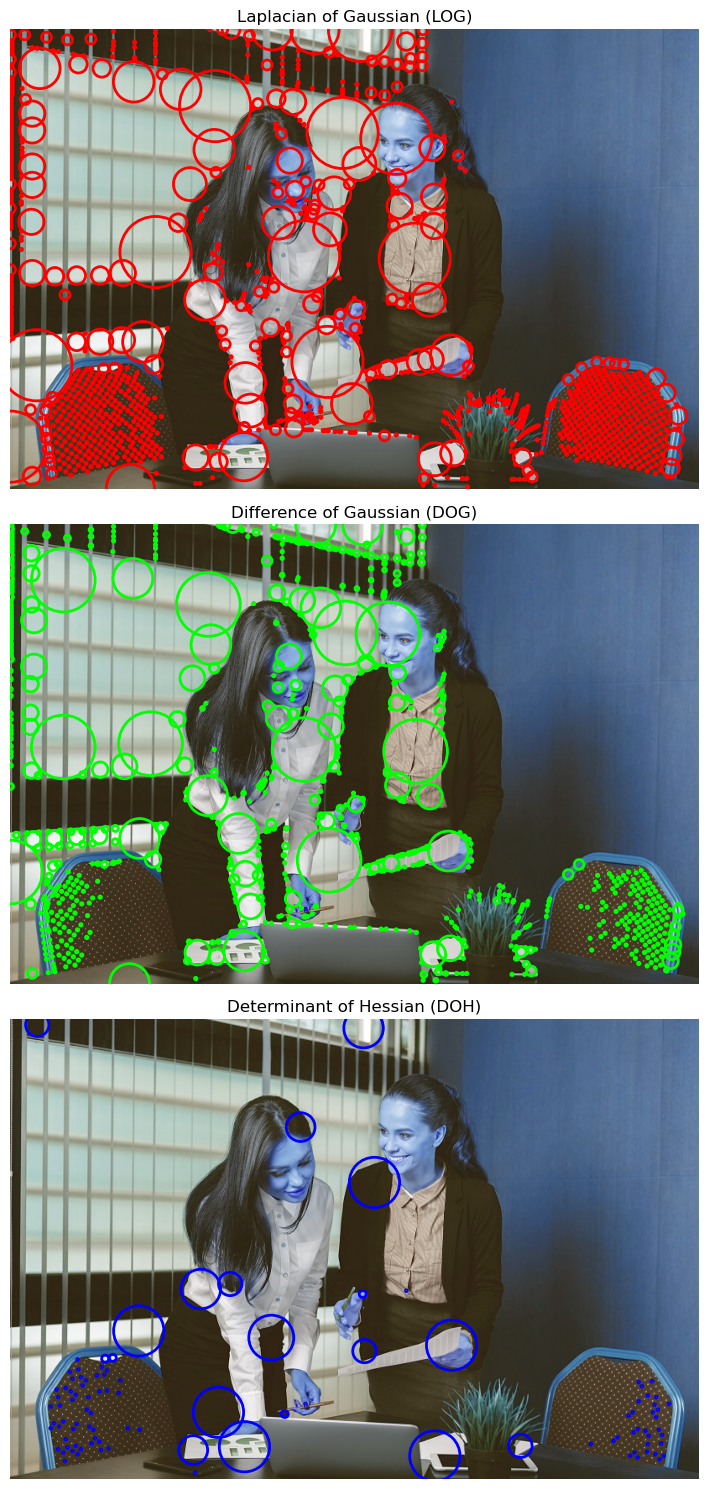

In [23]:
from skimage import data, color
from skimage.feature import blob_log, blob_dog, blob_doh
from skimage.io import imread
from skimage.color import rgb2gray

image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
gray_image = rgb2gray(image_rgb)

# Blob detection using Laplacian of Gaussian (LOG)
blobs_log = blob_log(gray_image, max_sigma=30, num_sigma=10, threshold=.1)

# Compute radii in the 3rd column for LOG
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)                     # Shape = (n, 3) is (y, x, r) for draw a circles

# Blob detection using Difference of Gaussian (DOG)
blobs_dog = blob_dog(gray_image, max_sigma=30, threshold=.1)

# Compute radii in the 3rd column for DOG
blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)                     # Shape = (n, 3) is (y, x, r) for draw a circles

# Blob detection using Determinant of Hessian (DOH)
blobs_doh = blob_doh(gray_image, max_sigma=30, threshold=.01)      # Shape = (n, 3) is (y, x, r) for draw a circles


#----------------------------------------------------------------------------------------------
# Set up plotting
fig, ax = plt.subplots(3, 1, figsize=(10,15))
# LOG plot
ax[0].imshow(image, cmap='gray')
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax[0].add_patch(c)
ax[0].set_title("Laplacian of Gaussian (LOG)")
ax[0].axis('off')

# DOG plot
ax[1].imshow(image, cmap='gray')
for blob in blobs_dog:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='lime', linewidth=2, fill=False)
    ax[1].add_patch(c)
ax[1].set_title("Difference of Gaussian (DOG)")
ax[1].axis('off')

# DOH plot
ax[2].imshow(image, cmap='gray')
for blob in blobs_doh:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='blue', linewidth=2, fill=False)
    ax[2].add_patch(c)
ax[2].set_title("Determinant of Hessian (DOH)")
ax[2].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

### Blob for YOLO

In [118]:
#Getting Blob
blob = cv.dnn.blobFromImage(image, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False)
print(blob.shape)

#Blob Visualization
blob_viz = blob[0].transpose(1,2,0)
print(blob_viz.shape)
#blob_normalized = cv.normalize(blob_viz, None, 0, 255, cv.NORM_MINMAX)
#blob_normalized = np.uint8(blob_normalized)

#cv.imshow("Blob Img", cv.cvtColor(blob_viz, cv.COLOR_BGR2RGB))

#cv.imshow("Image", image)
#cv.waitKey(0)
#cv.destroyAllWindows()

(1, 3, 416, 416)
(416, 416, 3)


# Loading yoloV3 Networks

In [59]:
#Loading coco class labels
labels = []
with open(r"C:\Users\Fernanda Januar\yolov3\data\coco.names") as f:
    for line in f:
        labels.append(line.strip())
        #print(line.strip())
        #break
print(np.array(labels).shape)   #(80,)
f.close()

(80,)


In [105]:
'''occurrences = [value for value in layer_names if value.lower().startswith("yolo")]
print(occurrences)'''

['yolo_139', 'yolo_150', 'yolo_161']


In [83]:
'''for i in networks.getUnconnectedOutLayers():
    print(layer_names[i-1])'''

yolo_139
yolo_150
yolo_161


In [113]:
#Loading yoloV3 networks
cfgV3 = r"C:\Users\Fernanda Januar\yolov3\cfg\yolov3.cfg"
cfgV4 = r"C:\Users\Fernanda Januar\yoloV4\yolov4.cfg"
weightsV3 = r"C:\Users\Fernanda Januar\yolov3\yolov3.weights"
weightsV4 = r"C:\Users\Fernanda Januar\yoloV4\yolov4.weights"

networks = cv.dnn.readNetFromDarknet(cfgV4, weightsV4)

#Getting list names of all layers
layer_names = networks.getLayerNames()
#print("layers_names:", layers_names, "\n")

# Getting only output layers
output_layer_names = [layer_names[i-1] for i in networks.getUnconnectedOutLayers()]
#for i in networks.getUnconnectedOutLayers():
#    layers_names_output.append(layers_names[i-1])    #['yolo_82', 'yolo_94', 'yolo_106']

#------------------------------------------------------------------------------------------------------
# Setting minimum probability to eliminate weak predictions
probability_minimum = 0.5

# Setting threshold for filtering weak bounding boxes
# with non-maximum suppression
threshold = 0.3

# Generating colours "for representing every detected object"
# with function randint(low, high=None, size=None, dtype='l')
colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')    #(80, 3)

# Implementing Forward Pass

We use only the **output layers**

**output_layer_names = [layer_names[i-1] for i in networks.getUnconnectedOutLayers()]**

in YOLO because they are **the ones responsible for making the final predictions** (bounding boxes, object classes, confidence scores). The intermediate layers contribute to building feature maps but aren't directly used for inference. By focusing on **the detection layers**, we optimize the model’s performance and output.

In [119]:
blob.shape

(1, 3, 416, 416)

In [120]:
# Implementing forward pass with our blob and only through output layers
# Calculating at the same time, needed time for forward pass
networks.setInput(blob)    #Setting blob as input to network

start = time.time()
output_from_networks = networks.forward(output_layer_names)   #(3, (#, 85))
end = time.time()

print("Time detection {:.3f} second".format(end-start))

Time detection 0.598 second


In [111]:
output_layer_names

['yolo_139', 'yolo_150', 'yolo_161']

# Getting Bounding Boxes

In [131]:
# Preparing lists for detected bounding boxes,
# obtained confidences and class's number
h,w = image.shape[:2]
bounding_boxes = []
confidences = []
class_numbers = []

for result in output_from_networks:
    for detected_object in result:
        # Getting 80 classes' probabilities for current detected object
        class_prob = detected_object[5:]  #(output yolo = (pc,x,y,w,h,class0,class1,class2,...,class79))
        #print(scores)   #(80,)
        
        # Getting index of the class with the maximum value of probability
        class_current = np.argmax(class_prob) #Mengembalikan indeks dari elemen terbesar dalam array tersebut
        #print(class_current)
        
        # Getting value of probability for defined class
        confidence_current = detected_object[4]
        #print(confidence_current)
        
        # Eliminating weak predictions with minimum probability
        if confidence_current > probability_minimum:
            # Scaling bounding box coordinates to the initial image size
            # YOLO data format keeps coordinates for center of bounding box
            # and its current width and height
            # That is why we can just multiply them elementwise
            # to the width and height
            # of the original image and in this way get coordinates for center
            # of bounding box, its width and height for original image
            bounding_boxes_current = detected_object[0:4] * np.array([w,h,w,h])
            
            # Now, from YOLO data format, we can get top left corner coordinates
            # that are x_min and y_min
            x_center, y_center, box_width, box_height = bounding_boxes_current
            x_min = int(x_center - (box_width/2))
            y_min = int(y_center - (box_height/2))
            
            
            # Adding results into prepared lists
            bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
            confidences.append(float(confidence_current))
            class_numbers.append(class_current)

In [132]:
len(bounding_boxes)

49

# Non-maximum Suppression

In [133]:
#NMS --> Mengembalikan daftar indeks bounding boxes yang lolos seleksi NMS
NMS_result = cv.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)
print(len(NMS_result))

6


# Drawing bounding boxes and labels

In [134]:
counter = 1
if len(NMS_result) > 0:
    for i in NMS_result:
        print("Object {0}: {1}".format(counter, labels[class_numbers[i]]))
        counter += 1

        #Getting coordinate bounding boxes
        x_min, y_min = bounding_boxes[i][:2]
        box_width, box_height = bounding_boxes[i][2:]

        # Preparing colour for current bounding box
        # and converting from numpy array to list
        colour_box = colours[class_numbers[i]].tolist()

        #Drawing bounding boxes on the original image
        cv.rectangle(image, (x_min, y_min), (x_min+box_width, y_min+box_height), colour_box, 2)

        #Label
        text = "{}".format(labels[class_numbers[i]])
        cv.putText(image, text, (x_min-5, y_min-10), cv.FONT_HERSHEY_SIMPLEX, 1.0, colour_box, 2)

print("Bounding Detected: ", len(bounding_boxes))
print('Number of objects left after non-maximum suppression:', counter - 1)

Object 1: person
Object 2: chair
Object 3: chair
Object 4: person
Object 5: laptop
Object 6: pottedplant
Bounding Detected:  49
Number of objects left after non-maximum suppression: 6


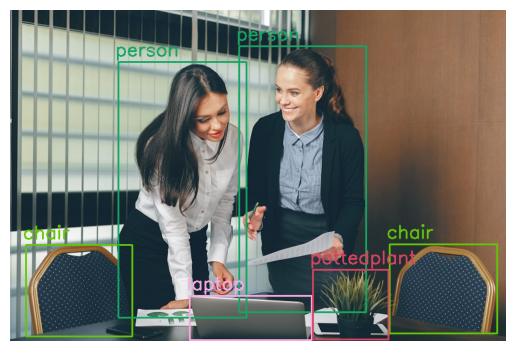

In [135]:
'''cv.namedWindow("Detection object", cv.WINDOW_NORMAL)
cv.imshow("Detection object", image)
cv.waitKey(0)
cv.destroyAllWindows()'''

plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()